In [1]:
TF_ENABLE_ONEDNN_OPTS=0

In [2]:
import os
import json
import requests
# from apex import amp
from PIL import Image
from io import BytesIO
from pycocotools.coco import COCO
import torchvision.transforms as transforms
from torchvision.datasets import CocoCaptions
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

/home/poison/miniconda3/envs/vault/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-18 10:45:09.869673: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 10:45:09.905563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 10:45:10.616725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find T

In [3]:
class COCODataset(Dataset):
    def __init__(self, data_dir, data_type, transform=None):
        self.data_dir = data_dir
        self.data_type = data_type
        self.transform = transform
        self.img_ids, self.captions = self.load_images_and_captions()
    
    def load_images_and_captions(self):
        # Load captions
        captions_path = os.path.join(self.data_dir, 'annotations', f'captions_{self.data_type}.json')
        with open(captions_path, 'r') as f:
            captions_data = json.load(f)
        captions = [caption['caption'] for caption in captions_data['annotations']]
        
        # Load image IDs
        img_ids = [img_info['id'] for img_info in captions_data['images']]
        
        return img_ids, captions

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        image_path = os.path.join(self.data_dir, self.data_type, f'{img_id:012d}.jpg')
        image = Image.open(image_path).convert('RGB')
        caption = self.captions[idx]
        if self.transform:
            image = self.transform(image)
        return image, caption

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
# Load dataset
data_dir = '/media/poison/Poison/UB_Academic/Sem2/DL/final_project/Dataset'  # Update this path
data_type = 'train2017'
dataset = COCODataset(data_dir, data_type, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# train_dataset = CocoCaptions(root=f'{data_dir}/train2017', annFile=f'{data_dir}/annotations/captions_train2017.json', transform=transform)
# dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, model_name='bert-base-uncased'):
        super(TextEncoder, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.bert = BertModel.from_pretrained(model_name)
    
    def forward(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True).to('cuda')
        outputs = self.bert(**inputs)
        return outputs.last_hidden_state.mean(dim=1)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(768, 256*16*16)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, text_features):
        x = self.fc(text_features)
        x = x.view(-1, 256, 16, 16)
        x = self.deconv(x)
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, stride=1, padding=0)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return torch.sigmoid(x.view(x.size(0), -1)).mean(1, keepdim=True)  # Ensure the output size is [batch_size, 1]


In [9]:
# Initialize models
text_encoder = TextEncoder().cuda()
generator = Generator().cuda()
discriminator = Discriminator().cuda()

/home/poison/miniconda3/envs/vault/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
# Define loss functions and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# TensorBoard writer
writer = SummaryWriter()

In [11]:
eval_texts = [
    "A cat sitting on a bench",
    "A beautiful landscape with mountains",
    "A group of people playing football",
    "A close-up of a colorful bird",
    "A city skyline at night"
]

In [12]:
def inference_pipeline(text_prompts,epoch):
    output_dir = "/media/poison/Poison/UB_Academic/Sem2/DL/final_project/lastday/generated_outs"
    os.makedirs(output_dir, exist_ok=True)
    text_encoder.eval()
    generator.eval()
    
    with torch.no_grad():

        for i,text in enumerate(text_prompts):
            text_features = text_encoder([text]).cuda()
            generated_image = generator(text_features)
            generated_image = generated_image.squeeze().cpu().numpy().transpose(1, 2, 0)
            generated_image = (generated_image + 1) / 2  # Denormalize

            plt.imshow(generated_image)
            plt.axis('off')
            plt.savefig(os.path.join(output_dir, f'epoch_{epoch}_image_{i}.png'))
            plt.close()
        
    return generated_image

In [14]:
def train_model(epochs, dataloader):
    text_encoder.train()
    generator.train()
    discriminator.train()
    
    train_losses_G = []
    train_losses_D = []
    
    for epoch in range(epochs):
        epoch_loss_G = 0
        epoch_loss_D = 0
        
        for i, (images, captions) in enumerate(dataloader):
            batch_size = images.size(0)
            images = images.cuda()
            valid = torch.ones(batch_size, 1).cuda()
            fake = torch.zeros(batch_size, 1).cuda()
            
            optimizer_G.zero_grad()
            
            text_features = text_encoder(captions).cuda()
            generated_images = generator(text_features)
            
            g_loss = adversarial_loss(discriminator(generated_images), valid)
            
            g_loss.backward()
            optimizer_G.step()
            

            optimizer_D.zero_grad()
            
            real_loss = adversarial_loss(discriminator(images), valid)
            fake_loss = adversarial_loss(discriminator(generated_images.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            
            d_loss.backward()
            optimizer_D.step()
            
            epoch_loss_G += g_loss.item()
            epoch_loss_D += d_loss.item()
            
            if i % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}')
        
        epoch_loss_G /= len(dataloader)
        epoch_loss_D /= len(dataloader)
        train_losses_G.append(epoch_loss_G)
        train_losses_D.append(epoch_loss_D)
        
        # Logging the epoch losses
        writer.add_scalar('Loss/Generator', epoch_loss_G, epoch)
        writer.add_scalar('Loss/Discriminator', epoch_loss_D, epoch)
        
        # Saving model checkpoints
        torch.save({
            'epoch': epoch + 1,
            'text_encoder_state_dict': text_encoder.state_dict(),
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'loss_G': epoch_loss_G,
            'loss_D': epoch_loss_D,
        }, f'checkpoint_epoch_{epoch+1}.pth')

        inference_pipeline(eval_texts,epoch)

    return train_losses_G, train_losses_D


# Training the model
train_losses_G, train_losses_D = train_model(epochs=20, dataloader=dataloader)

writer.close()


Epoch [1/20], Step [1/3697], G Loss: 0.5216, D Loss: 0.7372
Epoch [1/20], Step [101/3697], G Loss: 3.7067, D Loss: 0.0365
Epoch [1/20], Step [201/3697], G Loss: 4.1335, D Loss: 0.0165
Epoch [1/20], Step [301/3697], G Loss: 2.3326, D Loss: 0.0560
Epoch [1/20], Step [401/3697], G Loss: 4.9544, D Loss: 0.0081
Epoch [1/20], Step [501/3697], G Loss: 4.9430, D Loss: 0.0074
Epoch [1/20], Step [601/3697], G Loss: 5.7415, D Loss: 0.0034
Epoch [1/20], Step [701/3697], G Loss: 6.6276, D Loss: 0.0010
Epoch [1/20], Step [801/3697], G Loss: 7.1806, D Loss: 0.0005
Epoch [1/20], Step [901/3697], G Loss: 7.2430, D Loss: 0.0010
Epoch [1/20], Step [1001/3697], G Loss: 1.8218, D Loss: 0.1478
Epoch [1/20], Step [1101/3697], G Loss: 5.0292, D Loss: 0.0097
Epoch [1/20], Step [1201/3697], G Loss: 4.6713, D Loss: 0.0200
Epoch [1/20], Step [1301/3697], G Loss: 5.6265, D Loss: 0.0031
Epoch [1/20], Step [1401/3697], G Loss: 6.3991, D Loss: 0.0018
Epoch [1/20], Step [1501/3697], G Loss: 6.0155, D Loss: 0.0018
Epoc

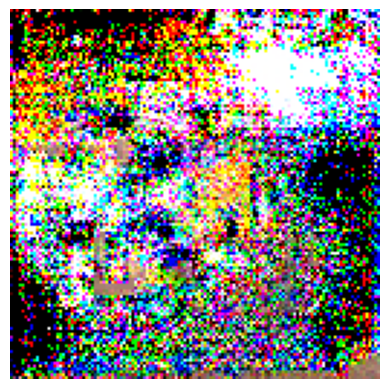

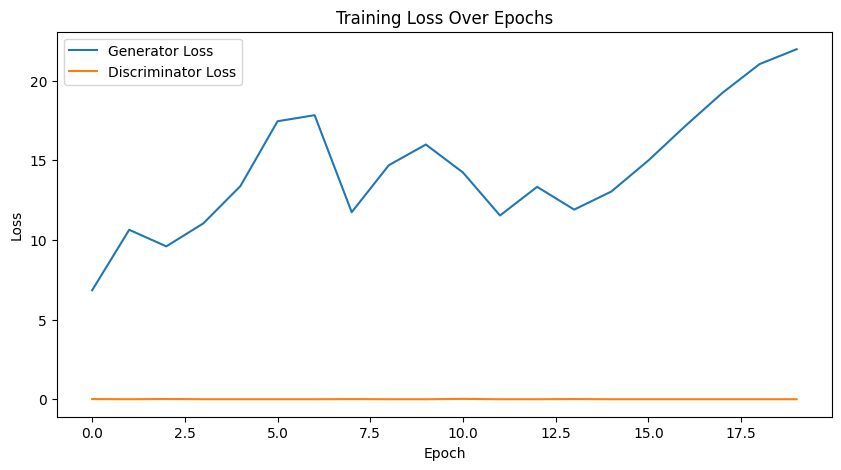

In [15]:
def generate_and_display(text):
    text_encoder.eval()
    generator.eval()
    
    with torch.no_grad():
        text_features = text_encoder([text]).cuda()
        generated_image = generator(text_features)
        
    generated_image = generated_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    generated_image = (generated_image + 1) / 2  # Denormalize
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()

def plot_losses(train_losses_G, train_losses_D):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_G, label='Generator Loss')
    plt.plot(train_losses_D, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

# Example usage
generate_and_display("A cat sitting on a bench")
plot_losses(train_losses_G, train_losses_D)


In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

text_encoder_params = count_parameters(text_encoder)
generator_params = count_parameters(generator)
discriminator_params = count_parameters(discriminator)

total_params = text_encoder_params + generator_params + discriminator_params

print(f"Total number of parameters in Text Encoder: {text_encoder_params}")
print(f"Total number of parameters in Generator: {generator_params}")
print(f"Total number of parameters in Discriminator: {discriminator_params}")
print(f"Total number of parameters Overall: {total_params}")

Total number of parameters in Text Encoder: 109482240
Total number of parameters in Generator: 51055811
Total number of parameters in Discriminator: 2766529
Total number of parameters Overall: 163304580
